# Preprocessing

Each wave must be preprocessed. This will include:
- Assigning labels according to the CESD-10 reporting scale
- Discretizing/classing continuous variables
- Feature Selection/Engineering
- Normalisation/Scaling

## Data Preparation

This includes:
1. Collecting each wave's .csv file
2. Renaming columns to make them more useable
3. Type fixing (Eg. Changing Date to datetime)
4. Incomplete data dropping (For the purpose of this Research, we only include data from participants who were 'Successfully Interviewed')

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotter
import importlib

from sklearn.utils import resample

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
importlib.reload(plotter)

wave_num = 3

path_to_file = f"WaveFiles/wave{wave_num}.csv"

df: pd.DataFrame = pd.read_csv(path_to_file)

# Selecting column names for CESD-10 Scale related features
cesd_col_names = ["_a_emobth", "_a_emomnd", "_a_emodep", "_a_emoeff", "_a_emohope",
                "_a_emofear", "_a_emoslp", "_a_emohap", "_a_emolone", "_a_emogo"]
# for i in range(len(cesd_col_names)): cesd_col_names[i] = f"w{wave_num}" + cesd_col_names[i]

# Columns relating to non-employment based income sources. EXCLUDED: incwar_v, inco
other_incomes = ["incgovpen_v", "incppen_v", "incret_v", "incretp_v", "incuif_v",
                 "incwc_v", "incdis_v", "incchld_v", "incfos_v", "inccare_v",
                 "incint_v", "incinh_v", "incrnt_v", "incretr_v",
                 "inclob_v", "incgif_v", "incloan_v", "incsale_v"]
for i in range(len(other_incomes)): other_incomes[i] = f"w{wave_num}_a_" + other_incomes[i]

new_df = pd.DataFrame({})

curr_year = 0
if wave_num == 1: curr_year = '8'
if wave_num == 2: curr_year = '10'
if wave_num == 3: curr_year = '12'
if wave_num == 4: curr_year = '14'
if wave_num == 5: curr_year = '17'

# Rename specific columns
df = df.rename(columns={f'w{wave_num}_a_gen': 'gender',
                        f'w{wave_num}_a_dob_y': 'birth_year',
                        f'w{wave_num}_a_popgrp': 'race',
                        f'w{wave_num}_a_marstt': 'marital_status',
                        f'w{wave_num}_a_brnprov': 'born_province',

                        f'w{wave_num}_a_mthali': 'parents_alive',

                        f'w{wave_num}_a_em1': 'employed',
                        f'w{wave_num}_a_em1pay': 'employed_take_home',
                        f'w{wave_num}_a_em1hrs': 'employed_weekly_hours',
                        f'w{wave_num}_a_ems': 'self_employed',
                        f'w{wave_num}_a_emsincmn': 'self_employed_take_home',
                        f'w{wave_num}_a_emshrs': 'self_employed_weekly_hours',
                        f'w{wave_num}_a_emc': 'casual_work',
                        f'w{wave_num}_a_emchrs': 'casual_weekly_hours',

                        f'w{wave_num}_a_edschgrd': 'highest_grade_school',
                        f'w{wave_num}_a_edter': 'tertiary_education',
                        # f'w{wave_num}_a_ed07att': 'attended_courses',
                        f'w{wave_num}_a_ed{curr_year}cur': 'currently_enrolled',

                        f'w{wave_num}_a_hldes': 'health_status',
                        f'w{wave_num}_a_hlcon': 'time_since_prev_consulation',
                        f'w{wave_num}_a_hlconmed': 'medicine_prescribed_at_prev_consulation'
                        })

outcome_str = f'w{wave_num}_a_outcome'
new_data = df[df[outcome_str] == 'Successfully Interviewed']
df = new_data

df

/tmp/ipykernel_428677/1746471459.py:7: DtypeWarning: Columns (7,8,9,10,11,14,18,19,26,30,31,32,33,34,37,39,41,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,66,68,69,70,71,72,73,74,76,77,78,79,80,81,82,84,85,86,87,88,89,90,92,93,94,95,96,97,98,100,101,102,103,104,105,106,108,109,110,111,112,113,114,116,117,118,119,120,121,122,124,125,126,127,128,129,130,132,133,134,135,136,137,138,140,141,142,143,144,145,146,148,149,150,151,152,153,154,156,157,158,159,160,161,162,164,165,166,167,168,169,170,172,173,174,177,178,181,182,183,184,185,186,187,190,194,195,196,197,198,199,201,203,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,234,235,236,237,238,239,240,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,295,297,299,300,301,302,303,304,305,306,307,308,309,311,312,313,314,315,316,317,319,320,

,w3_hhid,pid,w3_a_outcome,w3_a_intrv_c,w3_a_intrv_d,w3_a_intrv_m,w3_a_intrv_y,w3_a_refexpl,w3_a_refexpl_o,w3_a_refint,...,w3_a_intlng4,w3_a_intlng5,w3_a_intlng6,w3_a_intresp,w3_a_intrespact,w3_a_intresphear,w3_a_intrespque,w3_a_intresppid1,w3_a_intresppid2,w3_a_intresppid3
481,305985,591460,Successfully Interviewed,1002.0,1st,May,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Hostile,Not at all attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
815,305366,310896,Successfully Interviewed,1002.0,1st,July,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Hostile,Not at all attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
818,306655,305742,Successfully Interviewed,70.0,1st,August,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
1052,308518,319422,Successfully Interviewed,1002.0,17th,June,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Hostile,Not at all attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
1406,302517,734555,Successfully Interviewed,1002.0,28th,July,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,No other person within hearing range at any time,No,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22452,303186,317569,Successfully Interviewed,58.0,29th,October,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,1+ persons within hearing range for part of th...,No,NaN,NaN,NaN
22453,302272,303655,Successfully Interviewed,40.0,10th,June,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,1+ persons within hearing range for all of the...,No,NaN,NaN,NaN
22454,309933,317568,Successfully Interviewed,82.0,31st,October,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Very attentive,1+ persons within hearing range for all of the...,No,NaN,NaN,NaN
22455,307026,312007,Successfully Interviewed,28.0,22nd,August,2012.0,NaN,NaN,NaN,...,NaN,NaN,NaN,Friendly,Not at all attentive,No other person within hearing range at any time,No,NaN,NaN,NaN


## Feature Engineering

In [3]:
'''
PID : Integer

Uniquely identifes each participant. We have to include this to ensure that when deriving new columns, we index by pid.
So that each value in the new column is correctly associated with the partcipant
'''
new_df['pid'] = df['pid']

### Section B: Demographics

pid    18689
age    18686
dtype: int64
pid       14921
age       14921
gender    14921
dtype: int64


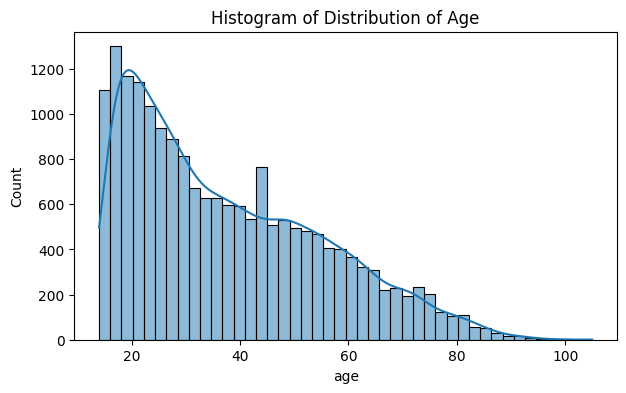

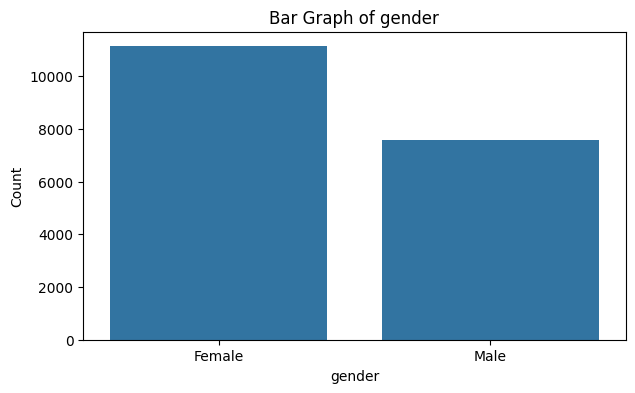

In [4]:
# Temporary dataframe used to mainting indexing when deriving new columns
temp_df = pd.DataFrame({})

'''
AGE (Derived) : Integer

Provides the age of the participant at the time of the interview.
'''
# Calculated age by taking interview year minus year of birth
years: pd.Series = df['birth_year'].replace('Missing', pd.NA).replace("Don't know", pd.NA).replace("Refused", pd.NA).dropna()
# years = years.fillna(years.mode()[0])
df['age'] = df[f'w{wave_num}_a_intrv_y'] - years.astype(float)
new_df['age'] = df['age'].astype('Int32')

plotter.plot_histogram(new_df['age'], "Distribution of Age")

print(new_df.count())

'''
GENDER : Integer (Class)

Factorizes gender.
'''
temp_df['gender'], getGender = pd.factorize(df['gender'])
# print("GENDER:", getGender,"\n", temp_df['gender'].unique())

# fig, axs = plt.subplots(1, 2, figsize=(14, 4))
plotter.plot_bar(df['gender'], title="gender", log_scale=False)

new_df['gender'] = temp_df['gender'].fillna(temp_df['gender'].mode()[0])

# # Check which rows have NaN values
# nan_rows = new_df[new_df.isna().any(axis=1)]

# # Print rows with NaN values
# print(nan_rows)


new_df = new_df.dropna()

print(new_df.count())

RACE: Index(['African', 'Coloured', 'Asian/Indian', 'White'], dtype='object') 
 [0 1 2 3]
MARITAL_STATUS: Index(['Married', 'Never married', 'Widow/Widower', 'Missing',
       'Living with partner', 'Divorced or separated', 'Don't know',
       'Refused'],
      dtype='object') 
 [0 1 2 3 4 5 6 7]
BORN_PROVINCE: Index(['Eastern Cape', 'Northern Cape', 'Limpopo', 'KwaZulu-Natal',
       'Western Cape', 'Mpumalanga', 'Free State', 'Gauteng', 'North West',
       'Outside RSA', 'Don't know'],
      dtype='object') 
 ['Eastern Cape' 'Northern Cape' 'Limpopo' 'KwaZulu-Natal' 'Western Cape'
 'Mpumalanga' 'Free State' 'Gauteng' 'North West' 'Outside RSA'
 "Don't know"]
pid               14921
age               14921
gender            14921
race              14921
marital_status    14921
born_province     14921
dtype: int64
pid               14921
age               14921
gender            14921
race              14921
marital_status    14921
born_province     14921
dtype: int64


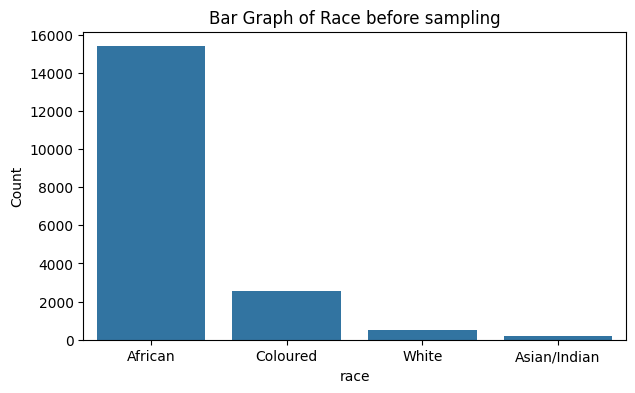

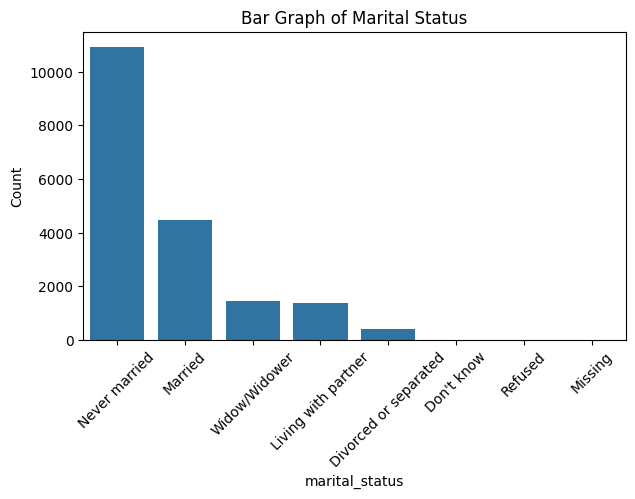

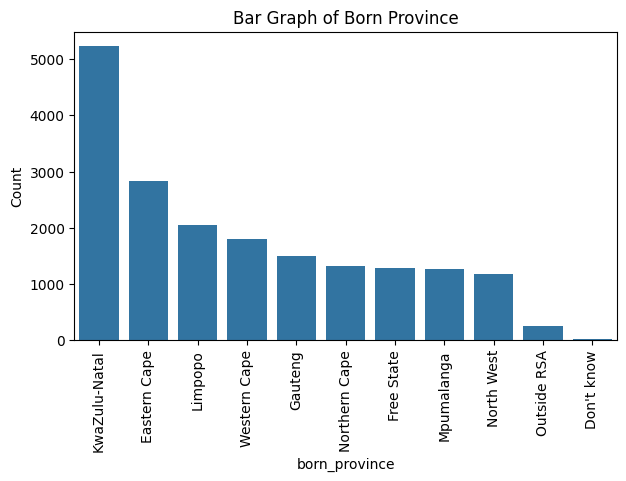

In [5]:
'''
RACE : Integer (Class)

Any nan or missing entries were replaced with the class "Other". This helps retain as much info as possible.
'''
# Combined Nan and Missing entries together as their own class and factorized
df['race'] = df['race'].replace(pd.NA, 'Other').replace('Missing', 'Other')
temp_df['race'], getRace = pd.factorize(df['race'])
print("RACE:", getRace,"\n", temp_df['race'].unique())

plotter.plot_bar(df['race'], title="Race before sampling", log_scale=False)

new_df['race'] = temp_df['race']

'''
MARITAL_STATUS : Integer (Class)

Includes missing as an option/value.
'''
temp_df['marital_status'], getMaritalStatus = pd.factorize(df['marital_status'])
print("MARITAL_STATUS:", getMaritalStatus,"\n", temp_df['marital_status'].unique())

plotter.plot_bar(df['marital_status'], title="Marital Status", log_scale=False, rotation=45)

new_df['marital_status'] = temp_df['marital_status']

'''
BORN_PROVINCE : Integer (Class)

Replaced Nan values with Missing. Importantly, about half of wave 1 seem to 
'''

df['born_province'] = df['born_province'].replace(pd.NA, "Missing")
# df['born_province'] = df['born_province'].dropna()
temp_df['born_province'], getBornProvince = pd.factorize(df['born_province'])
print("BORN_PROVINCE:", getBornProvince,"\n", df['born_province'].unique())

plotter.plot_bar(df['born_province'], title="Born Province", log_scale=False, rotation=90)

new_df['born_province'] = temp_df['born_province']

print(new_df.count())

new_df = new_df.fillna(new_df.mode())

print(new_df.count())

### Section C1: Children ever born (Only for Females)

### Section D: Parents’ education, living arrangements and vital status

### Section E: Labour market participation

Also includes Section F1: Individual income from non-employment sources

EMPLOYED: Index(['No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3]
SELF_EMPLOYED: Index(['Yes', 'No', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3]


KeyError: 'self_employed_take_home'

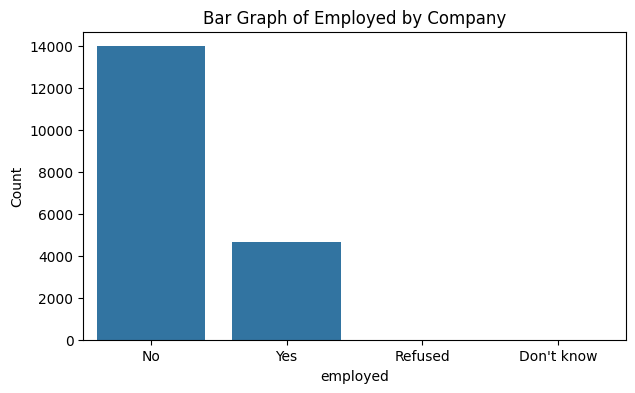

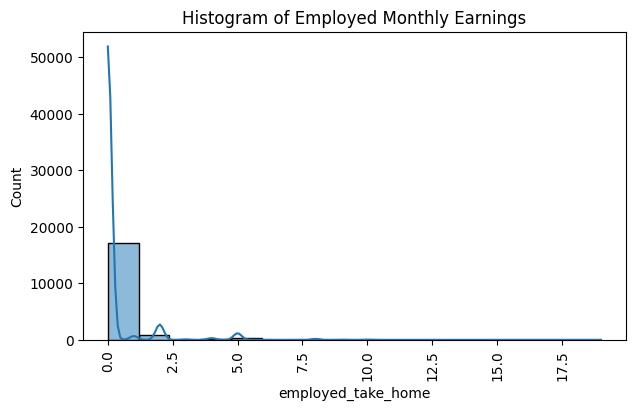

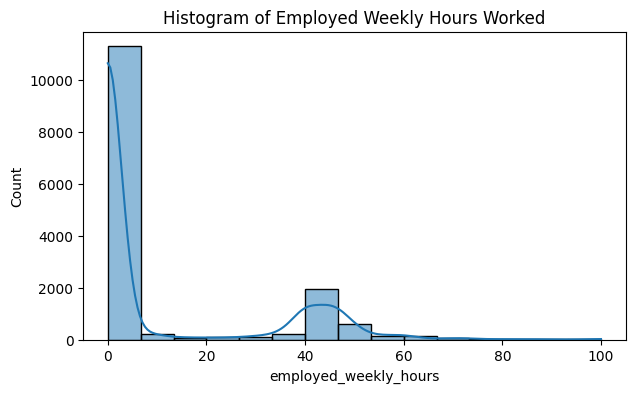

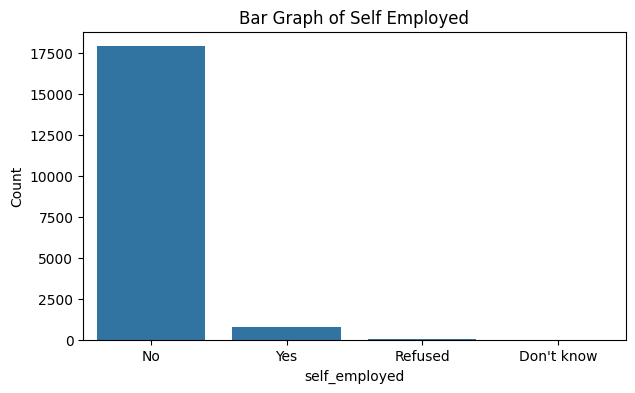

In [6]:
'''
EMPLOYED : Integer (Class)

1 or 0 if participant is employed at some company. Missing replaced with Refused since both indicate similar decisions
'''
df['employed'] = df['employed'].replace('Missing', 'Refused')
temp_df['employed'], getEmployedBool = pd.factorize(df['employed'])
print("EMPLOYED:", getEmployedBool,"\n", temp_df['employed'].unique())

plotter.plot_bar(df['employed'], title="Employed by Company", log_scale=False, rotation=0)

new_df['employed'] = temp_df['employed']

'''
EMPLOYED_TAKE_HOME : FLOAT -> Integer (Class)

Replaced any item that was a string or NA with 0. The amounts are discretized into bins.
'''
df['employed_take_home'] = df['employed_take_home'].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)

temp_df['employed_take_home'], getEmployedTakeHome = pd.factorize(pd.cut(pd.to_numeric(df['employed_take_home']), bins=30))

plotter.plot_histogram(temp_df['employed_take_home'], title="Employed Monthly Earnings", log_scale=False, rotation=90)

new_df['employed_take_home'] = temp_df['employed_take_home']

'''
EMPLOYED_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['employed_weekly_hours'] = df['employed_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['employed_weekly_hours'] =  pd.to_numeric(df['employed_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['employed_weekly_hours'] = df['employed_weekly_hours'].clip(upper=100)

plotter.plot_histogram(temp_df['employed_weekly_hours'], title="Employed Weekly Hours Worked", log_scale=False, rotation=0)

new_df['employed_weekly_hours'] = temp_df['employed_weekly_hours'] 


'''
SELF_EMPLOYED : Integer (Class)

1 or 0 if participant is self employed. Missing replaced with Refused since both indicate similar decisions
'''
df['self_employed'] = df['self_employed'].replace('Missing', 'Refused')
temp_df['self_employed'], getSelfEmployedBool = pd.factorize(df['self_employed'])
print("SELF_EMPLOYED:", getSelfEmployedBool,"\n", temp_df['self_employed'].unique())

plotter.plot_bar(df['self_employed'], title="Self Employed", log_scale=False, rotation=0)

new_df['self_employed'] = temp_df['self_employed']

'''
SELF_EMPLOYED_TAKE_HOME : FLOAT -> Integer (Class)

Replaced any item that was a string or NA with 0. The amounts are discretized into bins.
'''
df['self_employed_take_home'] = df['self_employed_take_home'].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)

temp_df['self_employed_take_home'], getSelfEmployedTakeHome = pd.factorize(pd.cut(pd.to_numeric(df['self_employed_take_home']), bins=30))

plotter.plot_histogram(temp_df['self_employed_take_home'], title="Self Employed Monthly Earnings", log_scale=False, rotation=90)

new_df['self_employed_take_home'] = temp_df['self_employed_take_home']

'''
EMPLOYED_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['self_employed_weekly_hours'] = df['self_employed_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['self_employed_weekly_hours'] =  pd.to_numeric(df['self_employed_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['self_employed_weekly_hours'] = df['self_employed_weekly_hours'].clip(upper=100)

plotter.plot_histogram(temp_df['self_employed_weekly_hours'], title="Self Employed Weekly Hours Worked", log_scale=False, rotation=0)

new_df['self_employed_weekly_hours'] = temp_df['self_employed_weekly_hours'] 

'''
CASUAL_WORK : Integer (Class)

1 or 0 if participant is does casual work, eg. Farming, Vendoring. Missing replaced with Refused since both indicate similar decisions
'''
df['casual_work'] = df['casual_work'].replace('Missing', 'Refused')
temp_df['casual_work'], getCasualWorkBool = pd.factorize(df['casual_work'])
print("CASUAL_WORK:", getCasualWorkBool,"\n", temp_df['casual_work'].unique())

plotter.plot_bar(df['casual_work'], title="Casual Work", log_scale=False, rotation=0)

new_df['casual_work'] = temp_df['casual_work']

'''
CASUAL_WEEKLY_HOURS : Integer

Replaced any item that was a string or NA with 0. I haven't binned this feature since Hours worked weekly will have frequent hour amounts.
'''
df['casual_weekly_hours'] = df['casual_weekly_hours'].replace('Missing', 0).replace("Refused", 0).replace("Don't know", 0).replace(pd.NA, 0).replace("Not Applicable", 0)
df['casual_weekly_hours'] =  pd.to_numeric(df['casual_weekly_hours']).astype('Int32')

# CAPPED ENTRIES WHERE EMPLOYED WEEKLY HOURS IS GREATER THAN 100
# IF A PARTICIPANT HAS MORE THAN 100 HOURS WORKED, THIS GETS CLIPPED DOWN TO 100
temp_df['casual_weekly_hours'] = df['casual_weekly_hours'].clip(upper=100)

plotter.plot_histogram(temp_df['casual_weekly_hours'], title="Weekly Hours Worked for Casual Work", log_scale=False, rotation=0)

new_df['casual_weekly_hours'] = temp_df['casual_weekly_hours'] 

'''
EXTRA_INCOME (Derived) : Float

There are a list of columns relating to extra incomes received from various sources. These include government grants, gifts, dontations etc.

Each column will be summed to form a new column that represents the total income gained from extra sources, other than employment.
'''
# # Firstly replacing entries which aren't numbers with 0
# for income_type in other_incomes:
#     df[income_type] = df[income_type].replace('Missing', 0.0).replace("Refused", 0.0).replace("Don't know", 0.0).replace(pd.NA, 0.0).replace("Not Applicable", 0.0)
#     df[income_type] = pd.to_numeric(df[income_type])
#     print(df[income_type].unique())

# temp_df['extra_income'] = df[other_incomes[0]]
# for i in range(1, len(other_incomes)):
#     temp_df['extra_income'] += df[other_incomes[i]]

# plotter.plot_histogram(temp_df['extra_income'], title="Extra income gained from sources other than employment", log_scale=True, rotation=90)

# new_df['extra_income'] = pd.factorize(pd.cut(pd.to_numeric(temp_df['extra_income']), bins=30))

# print(temp_df['extra_income'].head(10))


### Section G: Personal ownership and debt

### Section H: Education

HIGHEST_GRADE_SCHOOL: Index(['No schooling', 'Grade 5/Std. 3', 'Grade 8/Std. 6/Form 1',
       'Grade 3/Std. 1', 'Grade 9/Std. 7/Form 2', 'Grade 1/Sub A/Class 1',
       'Grade 7/Std. 5', 'Grade 4/Std. 2', 'Grade 6/Std. 4',
       'Grade 11/Std. 9/Form 4',
       'Grade 12/Std. 10/Form 5/Matric/Senior Certificate',
       'Grade 10/Std. 8/Form 3', 'Grade 2/Sub B/Class 2', 'Other (specify)',
       'NTC 2', 'Refused', 'Missing', 'Don't know', 'NTC 1', 'NTC 3',
       'Grade R/0'],
      dtype='object') 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
TERTIARY_EDUCATION: Index(['Missing', 'No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3 4]
CURRENTLY_ENROLLED: Index(['Missing', 'No', 'Yes', 'Refused', 'Don't know'], dtype='object') 
 [0 1 2 3 4]


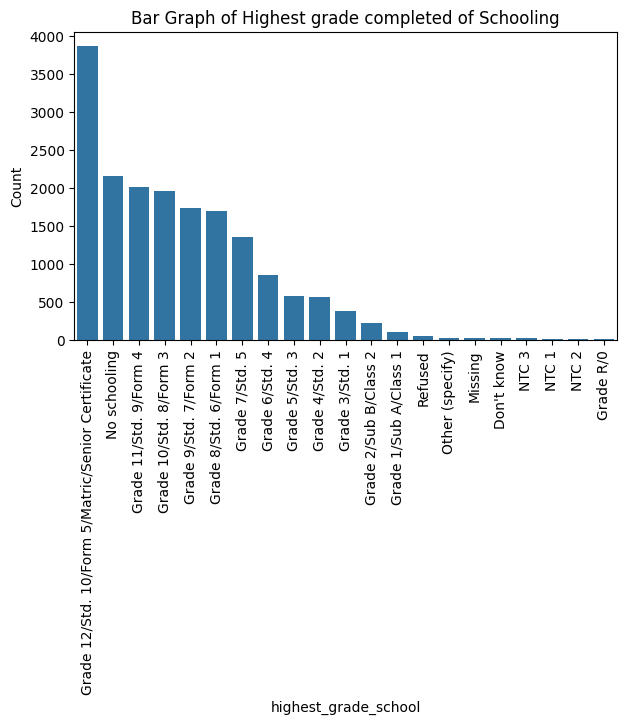

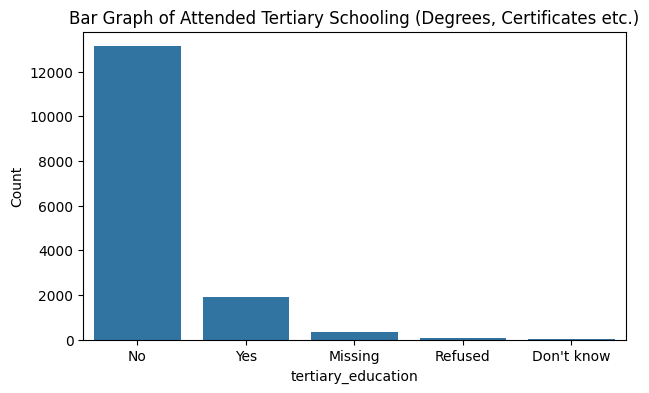

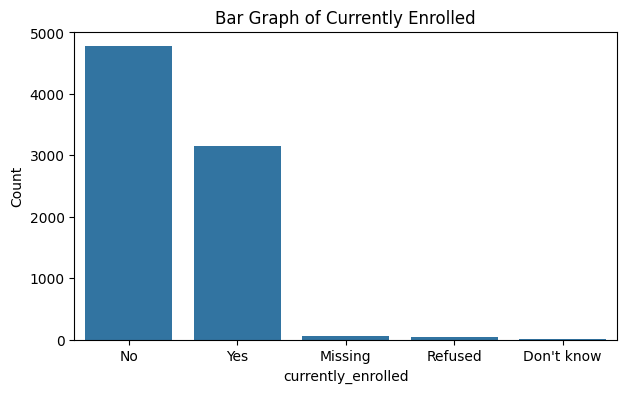

In [ ]:
'''
HIGHEST_GRADE_SCHOOL : Integer (Class)

Includes missing, refused, not applicable and don't know as options/values.
'''
temp_df['highest_grade_school'], getHighestGradeSchool = pd.factorize(df['highest_grade_school'])
print("HIGHEST_GRADE_SCHOOL:", getHighestGradeSchool,"\n", temp_df['highest_grade_school'].unique())

plotter.plot_bar(df['highest_grade_school'], title="Highest grade completed of Schooling", log_scale=False, rotation=90)

new_df['highest_grade_school'] = temp_df['highest_grade_school']

'''
TERTIARY_EDUCATION : Integer (Class)

Whether the participant completed some form of Tertiary Education (Degrees, Certificates etc.)

Includes missing, refused, and don't know as options/values.
'''
temp_df['tertiary_education'], getTertiaryEducation = pd.factorize(df['tertiary_education'].replace(pd.NA, 'Missing'))
print("TERTIARY_EDUCATION:", getTertiaryEducation,"\n", temp_df['tertiary_education'].unique())

plotter.plot_bar(df['tertiary_education'], title="Attended Tertiary Schooling (Degrees, Certificates etc.)", log_scale=False, rotation=0)

new_df['tertiary_education'] = temp_df['tertiary_education']

'''
CURRENTLY_ENROLLED : Integer (Class)

Whether the participant is enrolled in some form of Schooling or Education this year.

Includes missing as an option/value.
'''
temp_df['currently_enrolled'], getCurrentlyEnrolled = pd.factorize(df['currently_enrolled'].replace(pd.NA, 'Missing'))
print("CURRENTLY_ENROLLED:", getCurrentlyEnrolled,"\n", temp_df['currently_enrolled'].unique())

plotter.plot_bar(df['currently_enrolled'], title="Currently Enrolled", log_scale=False, rotation=0)

new_df['currently_enrolled'] = temp_df['currently_enrolled']

# '''
# ATTENDED_COURSES : Integer (Class)

# Whether the participant attended university/school courses in the prior year.

# Includes missing, refused, and don't know as options/values.
# '''
# temp_df['attended_courses'], getAttendedCourses = pd.factorize(df['attended_courses'].replace(pd.NA, 'Missing'))
# print("ATTENDED_COURSES:", getAttendedCourses,"\n", temp_df['attended_courses'].unique())

# plotter.plot_bar(df['attended_courses'], title="Attended Courses Last Year (Degrees, Certificates etc.)", log_scale=False, rotation=0)

# new_df['attended_courses'] = temp_df['attended_courses']



### Section J: Health

### Exporting Dataframes to CSV files

In [ ]:
for col in cesd_col_names:    
    # Header text for each column based on wave
    header = 'w' + str(wave_num)

    new_df[header+col] = df[header+col]

new_df.to_csv(f'CSV/wave{wave_num}_select.csv', index=False)

### Labelling

Each participant was **labelled according to the CESD-10 reporting scale**.

In [ ]:
import pandas as pd
from tqdm import tqdm
from typing import List
importlib.reload(plotter)

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

class Wave:
    def __init__(self, data: pd.DataFrame, select_cols: List[str]):
        self.data: pd.DataFrame = data
        self.select_cols: List[str] = select_cols
    
    def __str__(self):
        return str(self.data)

waves: List[Wave] = []

# Scoring dictionaries
normal_scoring = {
    'Rarely or none of the time (less than 1 day)': 0,
    'Some or little of the time (1-2 days)': 1,
    'Occasionally or a moderate amount of time (3-4 days)': 2,
    'All of the time (5-7 days)': 3
}

reverse_scoring = {
    'Rarely or none of the time (less than 1 day)': 3,
    'Some or little of the time (1-2 days)': 2,
    'Occasionally or a moderate amount of time (3-4 days)': 1,
    'All of the time (5-7 days)': 0
}

incidence = []

# Loop through each wave
for i in tqdm(range(1, 3), desc="Labelling Participants"):
    url = 'CSV/wave' + str(i) + '_select.csv'
    data = pd.read_csv(url)

    # Header text for each column based on wave
    header = 'w' + str(i)
    
    # Create the select columns
    select_cols = [header + col for col in cesd_col_names]

    # Filter rows based on valid CESD answers
    cesd_valid_answers = ['Rarely or none of the time (less than 1 day)',
                          'Some or little of the time (1-2 days)',
                          'Occasionally or a moderate amount of time (3-4 days)',
                          'All of the time (5-7 days)']
    
    # Only keep rows where all select_cols have valid answers
    # new_data = data[data[select_cols].isin(cesd_valid_answers).all(axis=1)].fillna(data.mode(), inplace=True)
    new_data = data[data[select_cols].isin(cesd_valid_answers).all(axis=1)]
    
    # Apply scoring to all CESD columns
    for idx, col in enumerate(select_cols):
        if idx == 4 or idx == 7:  # Reverse scoring for columns 5 and 8 (0-indexed as 4 and 7)
            new_data[col] = new_data[col].replace(reverse_scoring)
        else:
            new_data[col] = new_data[col].replace(normal_scoring)

    # Derive "Depressed" column: 1 if score >= 10, else 0
    new_data['score'] = new_data[select_cols].sum(axis=1)
    new_data['depressed'] = (new_data['score'] >= 10).astype(int)

    # Check which rows have NaN values
    nan_rows = new_data[new_data.isna().any(axis=1)]

    # Print rows with NaN values
    print(nan_rows)

    new_data.to_csv(f'CSV/wave{wave_num}_select_labelled.csv', index=False)

    percentage_depressed = plotter.get_percent_na(new_data['depressed'].replace(1, pd.NA))

    incidence.append(percentage_depressed)

    # Append the wave object to the list
    wave = Wave(new_data, select_cols)
    waves.append(wave)

for i in range(len(incidence)): print((f"Wave {i+1}: {round(incidence[i], 3)}% depressed"))


Labelling Participants:   0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_428532/4165266354.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[col] = new_data[col].replace(normal_scoring)
/tmp/ipykernel_428532/4165266354.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[col] = new_data[col].replace(reverse_scoring)
/tmp/ipykernel_428532/4165266354.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Empty DataFrame
Columns: [pid, age, gender, race, marital_status, born_province, employed, employed_take_home, employed_weekly_hours, self_employed, self_employed_take_home, self_employed_weekly_hours, casual_work, casual_weekly_hours, highest_grade_school, tertiary_education, currently_enrolled, w1_a_emobth, w1_a_emomnd, w1_a_emodep, w1_a_emoeff, w1_a_emohope, w1_a_emofear, w1_a_emoslp, w1_a_emohap, w1_a_emolone, w1_a_emogo, score, depressed]
Index: []

[0 rows x 29 columns]


/tmp/ipykernel_428532/4165266354.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[col] = new_data[col].replace(normal_scoring)
/tmp/ipykernel_428532/4165266354.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[col] = new_data[col].replace(reverse_scoring)
/tmp/ipykernel_428532/4165266354.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Empty DataFrame
Columns: [pid, age, gender, race, marital_status, born_province, employed, employed_take_home, employed_weekly_hours, self_employed, self_employed_take_home, self_employed_weekly_hours, casual_work, casual_weekly_hours, highest_grade_school, tertiary_education, currently_enrolled, w2_a_emobth, w2_a_emomnd, w2_a_emodep, w2_a_emoeff, w2_a_emohope, w2_a_emofear, w2_a_emoslp, w2_a_emohap, w2_a_emolone, w2_a_emogo, score, depressed]
Index: []

[0 rows x 29 columns]
Wave 1: 33.915% depressed
Wave 2: 24.285% depressed


### Ignore

In [ ]:
# from tqdm import tqdm
# import pandas as pd
# from typing import List, Dict, Tuple
# import warnings

# warnings.filterwarnings('ignore', category=FutureWarning)

# # Selecting column names for CESD-10 Scale related features
# cesd_col_names = ["_a_emobth", "_a_emomnd", "_a_emodep", "_a_emoeff", "_a_emohope",
#                 "_a_emofear", "_a_emoslp", "_a_emohap", "_a_emolone", "_a_emogo"]

# for wave in range(len(waves)):
#     print(f"Wave {wave+1}:")
#     data: pd.DataFrame = waves[wave].data
#     select_cols = waves[wave].get_select_cols()

#     # Dictionary to store the scores and depression status
#     scores: Dict[str, Dict] = dict()

#     # Series containing participant IDs
#     participants = data['pid']

#     # Counter for the number of participants flagged as depressed
#     count_depressed = 0

#     # Iterate over each participant
#     for participant in tqdm(participants, desc="Labelling Participants"):
#         score = 0
#         depressed = False

#         idx = data.index[data['pid'] == participant]

#         # Sum the scores for all relevant columns
#         for col in select_cols:
#             value = data.at[idx[0], col]  # Accessing the value using participant ID and column name
#             score += value

#         # Determine if the participant is depressed based on the score
#         if score >= 10:
#             depressed = True
#             count_depressed += 1

#         # Map the participant ID to their score and depression status
#         scores[participant] = {'score': int(score), 'Depressed': depressed}
    
#     data['depression_score'] = 0

#     for i in cesd_col_names:
#         data['depression_score'] += data[f"w{wave+1}{i}"]
    
#     # Create a new column 'new_column' based on a condition
#     data['depressed'] = data['depression_score'].apply(lambda x: 1 if x >= 10 else 0)

#     print(list(data['depressed']).count(1))

#     data.to_csv('wave1_select_labelled.csv')
#     # Print the total number of depressed participants
#     print(f"Total Depressed Participants: {count_depressed}")
#     print(f"Calculated Prevalence for Depression: {round(count_depressed/len(participants) * 100, 2)}%")



# Exploratory Data Analysis and Visualisation